# Steered MD analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import nglview as ng
from IPython.display import display
import pytraj as pt

In [2]:
import yaml
with open('../.defaults/config', 'r') as file:
    _settings = yaml.load(file, Loader=yaml.FullLoader)

## Load data

Select data:

In [4]:
system = widgets.Dropdown(options=os.listdir('../systems'), description='System:')
display(system)
state = widgets.RadioButtons(options=os.listdir(f'../systems/{system.value}'), description='State:')
display(state)
folder = widgets.Text(description='Folder:')
display(folder)

Dropdown(description='System:', options=('peptide-2', 'apo', 'peptide-2r', 'peptide-3u', 'reference', 'peptide…

RadioButtons(description='State:', options=('closed', 'open'), value='closed')

Text(value='', description='Folder:')

Go to folder:

In [5]:
if folder.value == '':
    folder_name = 'seeded-md'
elif 'seeded-md' in folder.value:
    folder_name = folder.value
else:
    folder_name = f'seeded-md_{folder.value}'
os.chdir(f'../systems/{system.value}/{state.value}/{folder_name}/steering')

Load PLUMED output:

In [6]:
data = pd.read_csv('steering.dat', delim_whitespace=True)
columns = data.columns[2:]
data = pd.read_csv('steering.dat', delim_whitespace=True, skiprows=5, header=None)
data.columns = columns
data.index = data['time']/1000

## Plot data

Text(0, 0.5, 'RMSD/$\\AA$')

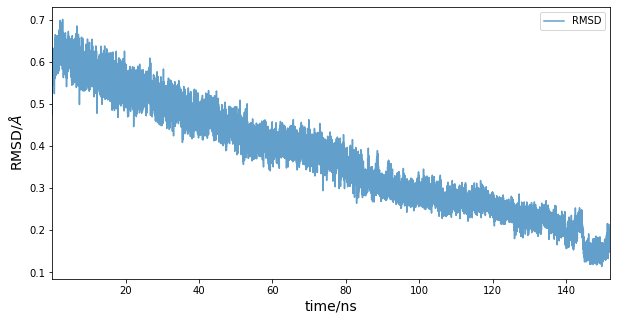

In [7]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(data.index, data['rmsd'], alpha=0.7, label='RMSD')

ax.legend()
ax.set_xlim(data.index[0], data.index[-1])
ax.set_xlabel('time/ns', size=14)
ax.set_ylabel('RMSD/$\AA$', size=14)

## Sample trajectory

Select snapshot number and set steering duration:

In [7]:
snapshot_number = widgets.IntText(value=100)
traj_duration = widgets.IntText(value=data.index.max()//10*10)
display(widgets.HBox([widgets.Label('Snapshot number:'), snapshot_number]))
display(widgets.HBox([widgets.Label('Trajectory duration/ns:'), traj_duration]))

In [8]:
last_frame = int(traj_duration.value/(data.index[2]-data.index[1]))
snapshot_idxs = np.linspace(0, last_frame, snapshot_number.value, dtype=int)

Check that the snapshots sample the conformational space well:

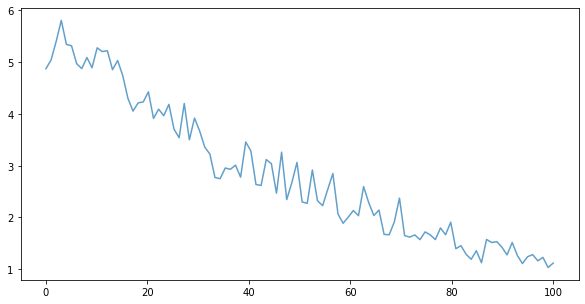

In [9]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(data.iloc[snapshot_idxs].index, data.iloc[:,1].iloc[snapshot_idxs]*10, alpha=0.7, label='Hinge')

Visualize trajectory:

In [ ]:
reference = pt.load('reference.pdb')

In [ ]:
trajectory = pt.load('steering_dry.nc', top='../../system-setup/system_dry.prm7')
trajectory = pt.align(trajectory, ':1-282&(@CA,C,N,O)', ref=reference, ref_mask=':1-282&(@CA,C,N,O)')

In [ ]:
view = ng.show_pytraj(trajectory)
view.clear_representations()
view.add_representation('cartoon', color='magenta')
view.add_component(reference)
view.component_1.clear_representations()
view.component_1.add_representation('cartoon', color='lightgreen')
view.display()

Save snapshots:

In [10]:
if not os.path.exists('../snapshots'):
    os.mkdir('../snapshots')

In [10]:
frame_idxs = []
for i, idx in enumerate(snapshot_idxs):
    snapshot = pt.load('steering_dry.nc', top='../../system-setup/system_dry.prm7', frame_indices=[idx])
    if not os.path.exists(f'../snapshots/snapshot_{i+1}.pdb'):
        pt.io.save_traj(f'../snapshots/snapshot_{i+1}.pdb', snapshot)
    frame_idxs.append(f'{i+1} {idx}\n')

In [11]:
with open('../snapshots/snapshot_idxs.txt', 'w') as file:
    file.writelines(frame_idxs)